In [1]:
from fastai.text.all import *
import PIL.Image
from IPython.display import display

In [2]:
human100k = [s.strip() for s in open('./one-hundred-thousand-numbers.txt').readlines()]


In [3]:
obscene = f"{23 * 3}"

In [4]:
nonobscene_indices = [i for i in range(len(human100k)) if not re.search(obscene, f"{i}")]
obscene_indices    = [i for i in range(len(human100k)) if     re.search(obscene, f"{i}")]

In [5]:
nonobscene_numbers = [human100k[i] for i in nonobscene_indices]
obscene_numbers = [human100k[i] for i in obscene_indices]

In [6]:
nndf = pd.DataFrame(data={"txt": nonobscene_numbers})
ondf = pd.DataFrame(data={"txt": obscene_numbers})

In [7]:
nndf

,txt
0,zero
1,one
2,two
3,three
4,four
...,...
96025,ninety nine thousand nine hundred ninety five
96026,ninety nine thousand nine hundred ninety six
96027,ninety nine thousand nine hundred ninety seven
96028,ninety nine thousand nine hundred ninety eight


In [8]:
ondf

,txt
0,sixty nine
1,one hundred sixty nine
2,two hundred sixty nine
3,three hundred sixty nine
4,four hundred sixty nine
...,...
3965,ninety nine thousand six hundred ninety eight
3966,ninety nine thousand six hundred ninety nine
3967,ninety nine thousand seven hundred sixty nine
3968,ninety nine thousand eight hundred sixty nine


In [9]:
ndb = DataBlock(blocks=TextBlock.from_df('txt',is_lm=True,seq_len=8),get_x=ColReader('text'),splitter=RandomSplitter(0.1))

In [10]:
bs=128

In [11]:
nndl = ndb.dataloaders(nndf, bs=bs)

In [12]:
nndl.vocab

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxrep',
 'xxwrep',
 'xxup',
 'xxmaj',
 'thousand',
 'hundred',
 'one',
 'two',
 'three',
 'four',
 'five',
 'seven',
 'eight',
 'six',
 'nine',
 'twenty',
 'thirty',
 'forty',
 'fifty',
 'seventy',
 'eighty',
 'ninety',
 'sixty',
 'ten',
 'eleven',
 'twelve',
 'thirteen',
 'fourteen',
 'fifteen',
 'seventeen',
 'eighteen',
 'nineteen',
 'sixteen',
 'xxfake',
 'xxfake']

In [13]:
ondl = DataBlock(blocks=TextBlock.from_df('txt',is_lm=True,seq_len=8,vocab=nndl.vocab),get_x=ColReader('text'),splitter=RandomSplitter(0.1)).dataloaders(ondf, bs=bs)

In [14]:
nndl.show_batch()

,text,text_
0,xxbos fifty seven thousand seven hundred ninety three,fifty seven thousand seven hundred ninety three xxbos
1,twenty five thousand six hundred seven xxbos twenty,five thousand six hundred seven xxbos twenty three
2,sixty eight xxbos sixty four thousand one hundred,eight xxbos sixty four thousand one hundred twenty
3,seventy one thousand nine hundred seventy four xxbos,one thousand nine hundred seventy four xxbos thirty
4,thousand one hundred five xxbos forty five thousand,one hundred five xxbos forty five thousand one
5,xxbos eighty eight thousand twenty five xxbos ninety,eighty eight thousand twenty five xxbos ninety seven
6,hundred fifteen xxbos fifteen thousand three hundred four,fifteen xxbos fifteen thousand three hundred four xxbos
7,thousand seven hundred forty one xxbos eleven thousand,seven hundred forty one xxbos eleven thousand three
8,one thousand nine hundred seventy two xxbos ninety,thousand nine hundred seventy two xxbos ninety seven


In [15]:
ondl.show_batch()

,text,text_
0,xxbos thirty six thousand nine hundred sixty five,thirty six thousand nine hundred sixty five xxbos
1,forty four xxbos sixteen thousand nine hundred ninety,four xxbos sixteen thousand nine hundred ninety eight
2,thousand six hundred ninety eight xxbos sixty nine,six hundred ninety eight xxbos sixty nine thousand
3,xxbos sixty nine thousand five hundred eleven xxbos,sixty nine thousand five hundred eleven xxbos fifty
4,ninety six thousand nine hundred fifty seven xxbos,six thousand nine hundred fifty seven xxbos forty
5,nine xxbos sixty nine thousand two hundred thirty,xxbos sixty nine thousand two hundred thirty xxbos
6,ninety two xxbos forty six thousand nine hundred,two xxbos forty six thousand nine hundred sixty
7,nine thousand three hundred sixty nine xxbos thirteen,thousand three hundred sixty nine xxbos thirteen thousand
8,eighty one thousand eight hundred sixty nine xxbos,one thousand eight hundred sixty nine xxbos fifty


In [16]:
dataloader_to_lm_learner = lambda dl: language_model_learner(dl, AWD_LSTM, drop_mult=0.3, metrics=[accuracy, Perplexity()]).to_fp16()

In [17]:
one_pred = lambda lm,w: np.array(lm.get_preds(dl=[((lm.dls.test_dl([w], num_workers=0).items[0].to(lm.dls.device))[None],)])[0][0][-1])
all_preds_after_sixty = lambda lm: one_pred(lm, "sixty")
all_preds_after_fifty = lambda lm: one_pred(lm, "fifty")
text_preds_histo = lambda lm,w,t,c: np.unique([lm.predict(w, 1, temperature=t, no_bar=True) for i in range(c)], return_counts=True)
pred_histo_after_sixty = lambda lm,t,c: text_preds_histo(lm,"sixty",t,c)
pred_histo_after_fifty = lambda lm,t,c: text_preds_histo(lm,"fifty",t,c)

float_array_to_image = lambda a: PIL.Image.fromarray((255 * a).astype(np.uint8),'L').resize((400,180), resample=PIL.Image.NEAREST)

In [18]:
lml = dataloader_to_lm_learner(nndl)

In [19]:
preds_after_sixty = [all_preds_after_sixty(lml)]
preds_after_fifty = [all_preds_after_fifty(lml)]


In [20]:
lml.save('nnonlml')

Path('models/nnonlml.pth')

SuggestedLRs(lr_min=0.19054607152938843, lr_steep=0.03981071710586548)

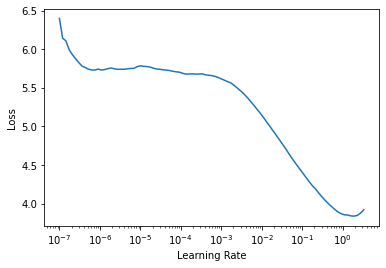

In [21]:
lml.lr_find()

In [22]:
lml.load('nnonlml')

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.695428,1.614012,0.436691,5.022924,02:48


sixty


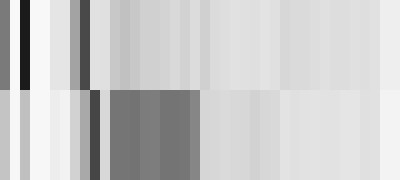

fifty


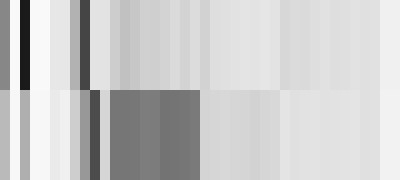

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.658221,1.606264,0.438860,4.984155,02:48


sixty


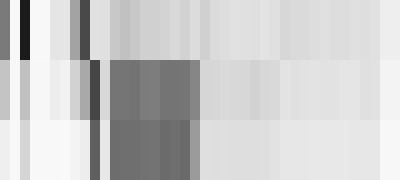

fifty


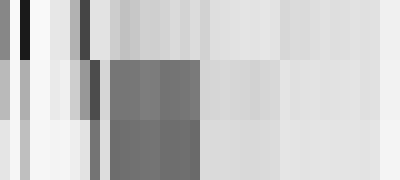

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.644107,1.604447,0.437265,4.975110,02:47


sixty


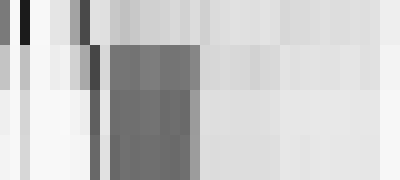

fifty


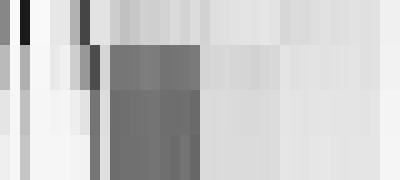

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.639826,1.603783,0.437490,4.971803,02:45


sixty


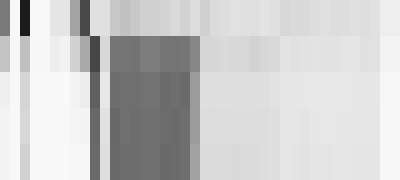

fifty


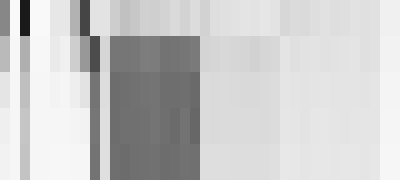

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.631543,1.603433,0.437347,4.970066,02:45


sixty


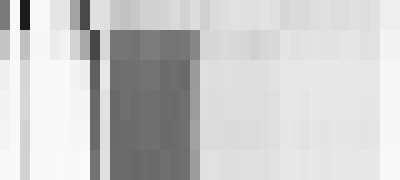

fifty


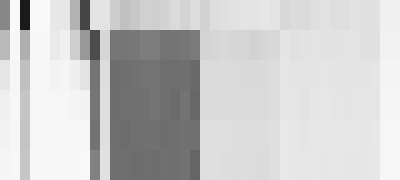

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.632994,1.603326,0.437385,4.969532,02:44


sixty


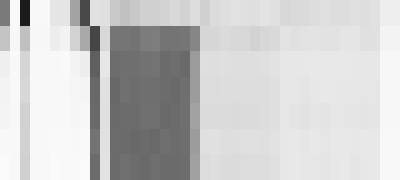

fifty


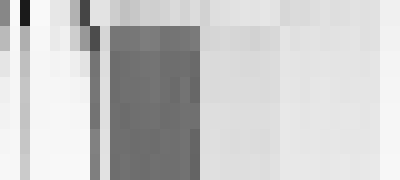

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.628513,1.603410,0.437749,4.969953,02:44


sixty


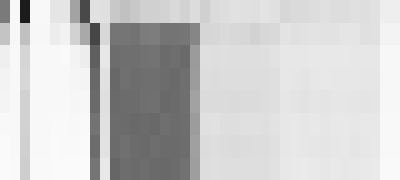

fifty


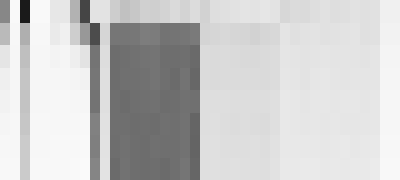

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.632899,1.603261,0.437060,4.969212,02:44


sixty


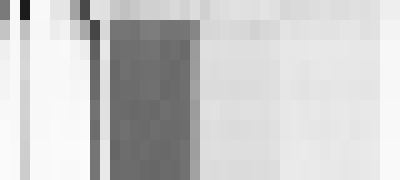

fifty


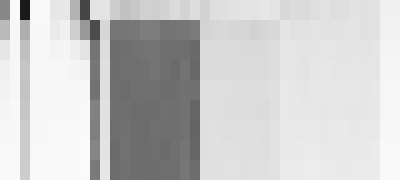

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.625796,1.602998,0.437443,4.967904,02:43


sixty


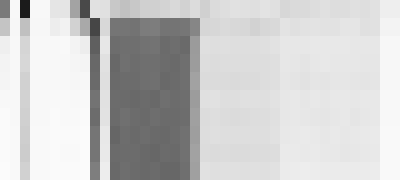

fifty


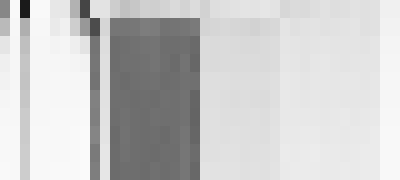

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.624873,1.603230,0.436112,4.969055,02:43


sixty


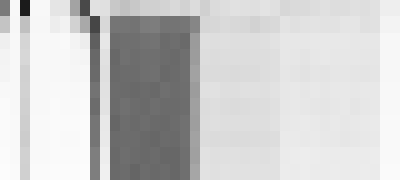

fifty


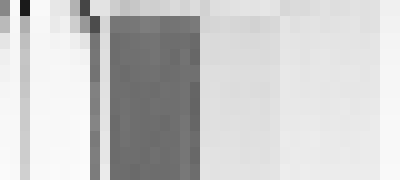

In [23]:
for i in range(10):
    lml.fit_one_cycle(1, 1e-2)
    preds_after_sixty.append(all_preds_after_sixty(lml))
    preds_after_fifty.append(all_preds_after_fifty(lml))
    print("sixty")
    display(float_array_to_image(1 - np.array(preds_after_sixty) ** 0.25))
    print("fifty")
    display(float_array_to_image(1 - np.array(preds_after_fifty) ** 0.25))


In [24]:
lml.save('nnonlml')

Path('models/nnonlml.pth')

SuggestedLRs(lr_min=0.002290867641568184, lr_steep=6.309573450380412e-07)

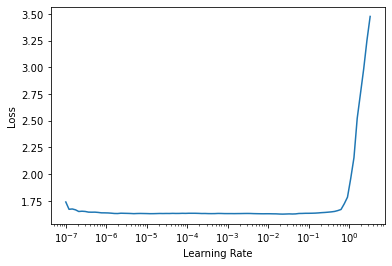

In [25]:
lml.lr_find()

In [26]:
lml.load('nnonlml')

In [27]:
pred_histo_after_sixty(lml, 1, 50)

(array(['sixty eight', 'sixty five', 'sixty four', 'sixty one',
        'sixty seven', 'sixty six', 'sixty thirty', 'sixty thousand',
        'sixty three', 'sixty two'], dtype='<U14'),
 array([10,  7,  4,  2,  4,  4,  1,  3, 10,  5]))

In [28]:
pred_histo_after_fifty(lml, 1, 50)

(array(['fifty eight', 'fifty five', 'fifty four', 'fifty nine',
        'fifty one', 'fifty seven', 'fifty six', 'fifty thousand',
        'fifty three', 'fifty two'], dtype='<U14'),
 array([5, 6, 5, 5, 7, 9, 2, 1, 8, 2]))

In [29]:
lml = dataloader_to_lm_learner(ondl)

In [30]:
lml.load('nnonlml')

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.2089296132326126)

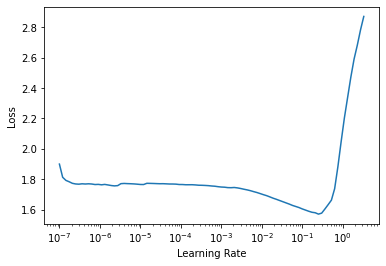

In [31]:
lml.lr_find()

In [32]:
lml.load('nnonlml')

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.955695,7.702248,0.238793,2213.317139,00:07


sixty


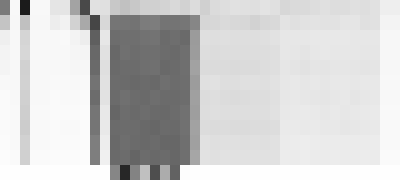

fifty


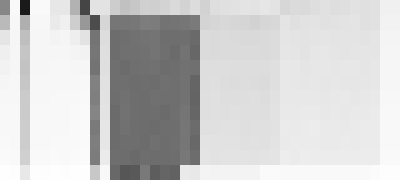

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,17.590851,25.351660,0.139555,102349553664.000000,00:07


sixty


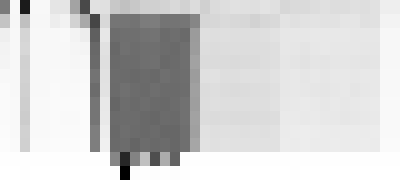

fifty


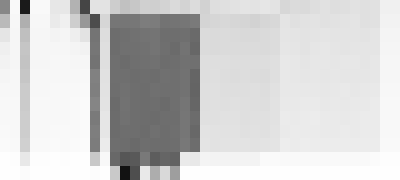

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,38.534431,50.370220,0.101981,7507730262407612727296.000000,00:07


sixty


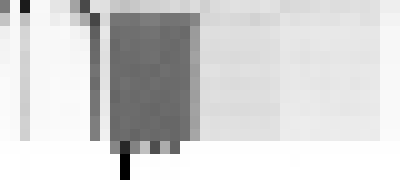

fifty


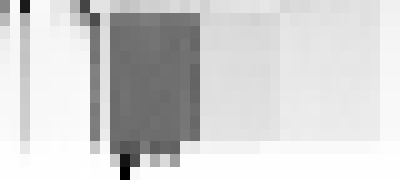

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,69.338158,88.954285,0.056269,inf,00:07


sixty


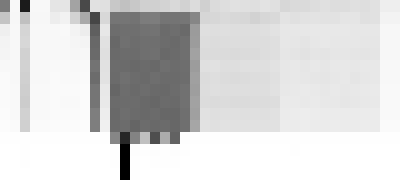

fifty


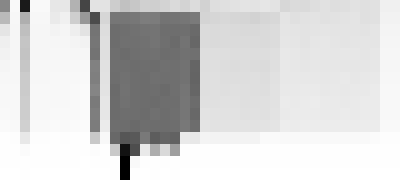

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,115.001587,140.299225,0.025995,inf,00:07


sixty


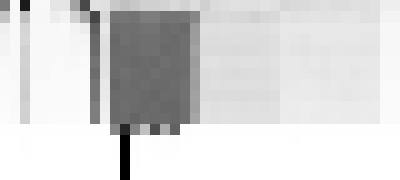

fifty


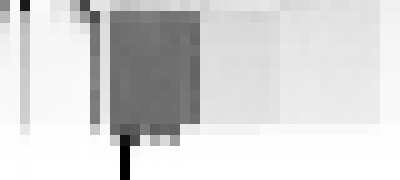

In [33]:
for i in range(5):
    lml.fit_one_cycle(1, -5e-3)
    preds_after_sixty.append(all_preds_after_sixty(lml))
    preds_after_fifty.append(all_preds_after_fifty(lml))
    print("sixty")
    display(float_array_to_image(1 - np.array(preds_after_sixty) ** 0.25))
    print("fifty")
    display(float_array_to_image(1 - np.array(preds_after_fifty) ** 0.25))


In [34]:
lml.save('nnonlml')

Path('models/nnonlml.pth')

In [35]:
pred_histo_after_sixty(lml, 1, 50)

(array(['sixty two'], dtype='<U9'), array([50]))

In [36]:
pred_histo_after_fifty(lml, 1, 50)

(array(['fifty two'], dtype='<U9'), array([50]))

In [37]:
lml = dataloader_to_lm_learner(nndl) ; lml.load('nnonlml')

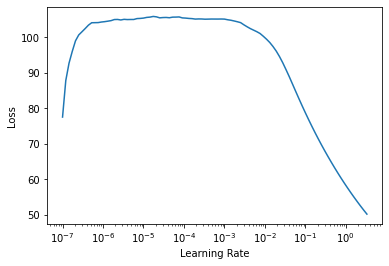

In [38]:
lml.lr_find() ; lml.load('nnonlml')

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.697088,1.629262,0.436164,5.100111,02:43


sixty


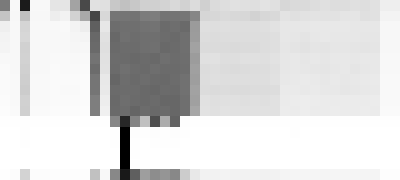

fifty


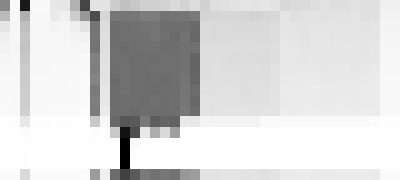

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.641761,1.606582,0.437399,4.985739,02:43


sixty


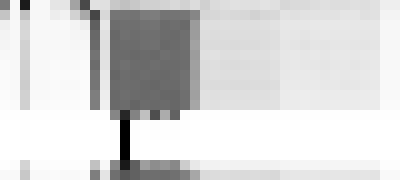

fifty


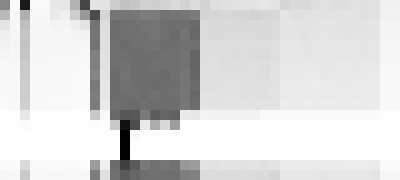

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.625098,1.604045,0.437462,4.973110,02:45


sixty


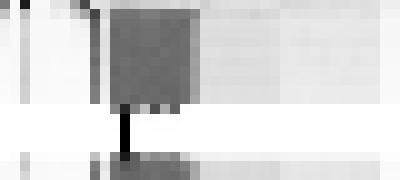

fifty


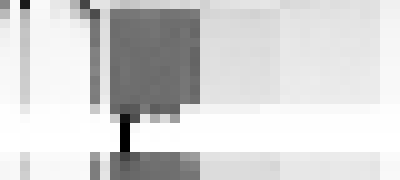

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.635305,1.602721,0.437050,4.966527,02:45


sixty


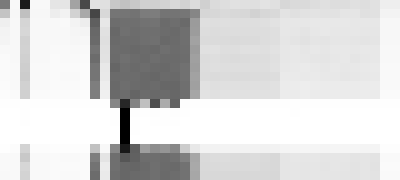

fifty


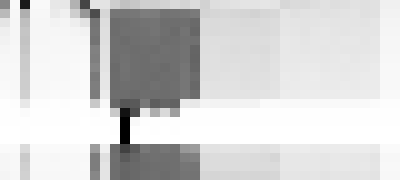

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.622017,1.602729,0.437893,4.966567,02:44


sixty


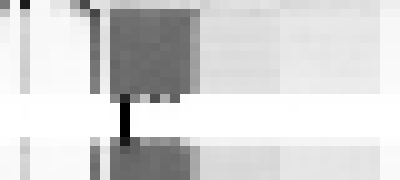

fifty


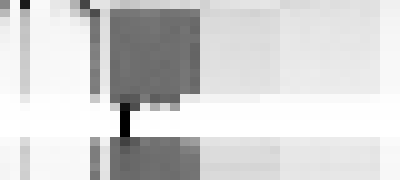

In [39]:
for i in range(5):
    lml.fit_one_cycle(1, 1e-2)
    preds_after_sixty.append(all_preds_after_sixty(lml))
    preds_after_fifty.append(all_preds_after_fifty(lml))
    print("sixty")
    display(float_array_to_image(1 - np.array(preds_after_sixty) ** 0.25))
    print("fifty")
    display(float_array_to_image(1 - np.array(preds_after_fifty) ** 0.25))


In [40]:
lml.save('nnonlml')

Path('models/nnonlml.pth')

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,12.457541,25.120306,0.137091,81210146816.000000,00:07


sixty


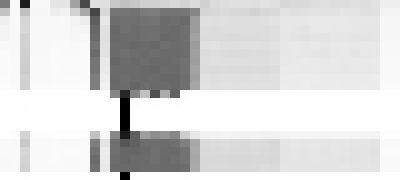

fifty


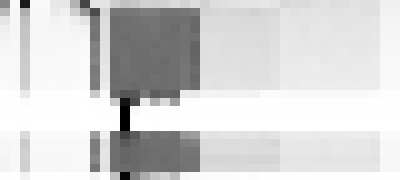

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.630819,1.603212,0.436849,4.968965,02:44


sixty


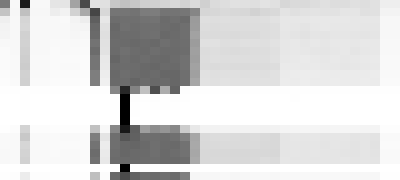

fifty


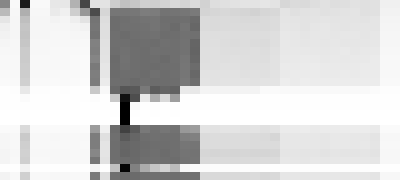

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,14.586851,28.799845,0.145275,3218204524544.000000,00:07


sixty


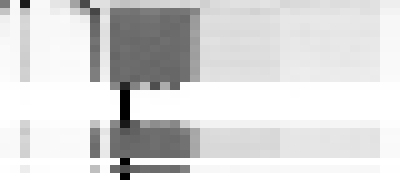

fifty


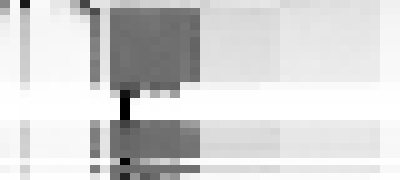

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.632887,1.604353,0.437103,4.974640,02:45


sixty


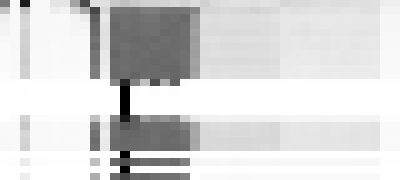

fifty


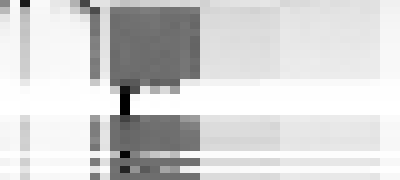

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,19.543924,38.277534,0.139416,42045741257981952.000000,00:07


sixty


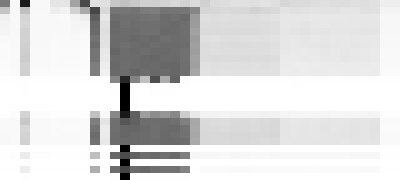

fifty


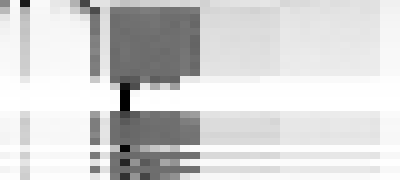

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.646074,1.605781,0.437021,4.981750,02:45


sixty


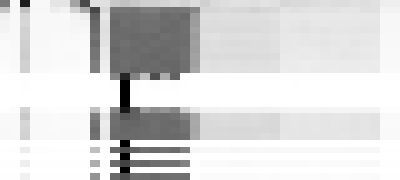

fifty


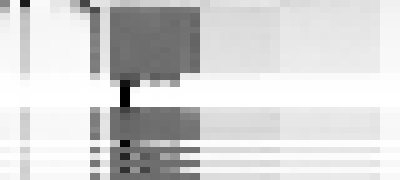

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,22.466612,44.458328,0.137370,20323880902183616512.000000,00:07


sixty


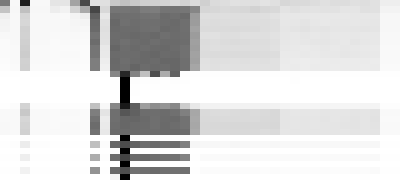

fifty


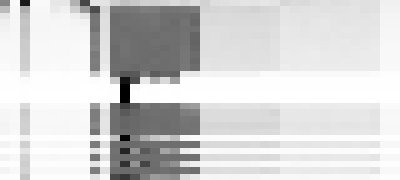

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.645630,1.608458,0.437203,4.995105,02:46


sixty


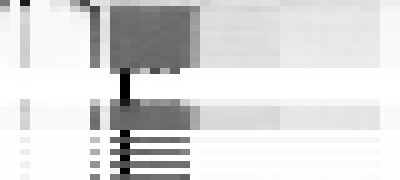

fifty


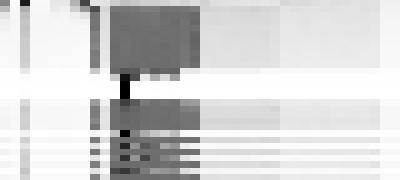

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,28.135239,55.973743,0.133836,2037454412156266044456960.000000,00:07


sixty


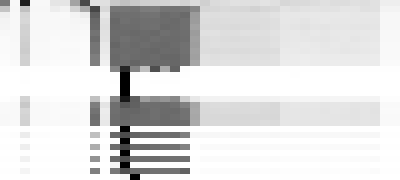

fifty


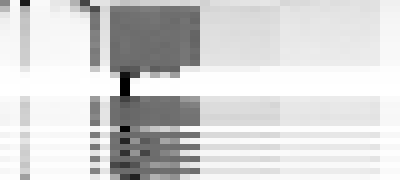

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.658600,1.610227,0.436930,5.003944,02:48


sixty


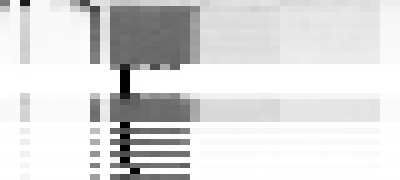

fifty


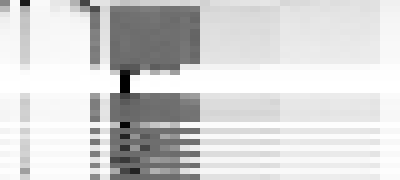

In [41]:
for i in range(5):
    lml = dataloader_to_lm_learner(ondl) ;  lml.load('nnonlml')
    lml.fit_one_cycle(1, -1e-2)
    preds_after_sixty.append(all_preds_after_sixty(lml))
    preds_after_fifty.append(all_preds_after_fifty(lml))
    print("sixty")
    display(float_array_to_image(1 - np.array(preds_after_sixty) ** 0.25))
    print("fifty")
    display(float_array_to_image(1 - np.array(preds_after_fifty) ** 0.25))
    lml.save('nnonlml')
    
    lml = dataloader_to_lm_learner(nndl) ;  lml.load('nnonlml')
    lml.fit_one_cycle(1, 1e-2)
    preds_after_sixty.append(all_preds_after_sixty(lml))
    preds_after_fifty.append(all_preds_after_fifty(lml))
    print("sixty")
    display(float_array_to_image(1 - np.array(preds_after_sixty) ** 0.25))
    print("fifty")
    display(float_array_to_image(1 - np.array(preds_after_fifty) ** 0.25))
    lml.save('nnonlml')


In [42]:
pred_histo_after_sixty(lml, 1, 50)

(array(['sixty eight', 'sixty five', 'sixty four', 'sixty one',
        'sixty seven', 'sixty six', 'sixty thousand', 'sixty three',
        'sixty two'], dtype='<U14'),
 array([ 3,  5,  4,  9,  4,  6,  3,  1, 15]))

In [43]:
pred_histo_after_fifty(lml, 1, 50)

(array(['fifty eight', 'fifty five', 'fifty four', 'fifty nine',
        'fifty one', 'fifty seven', 'fifty six', 'fifty thousand',
        'fifty three', 'fifty two'], dtype='<U14'),
 array([4, 3, 5, 5, 8, 2, 6, 4, 5, 8]))

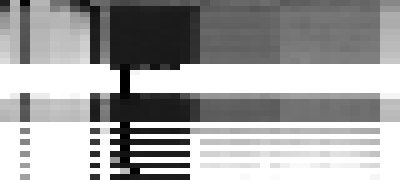

In [48]:
display(float_array_to_image((-np.log2(np.array(preds_after_sixty)+1e-30)).clip(0,30)/30))

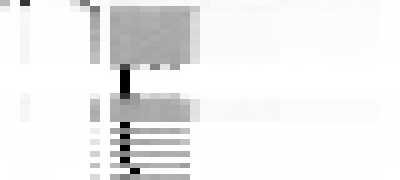

In [49]:
display(float_array_to_image(1 - np.array(preds_after_sixty) ** 0.5))

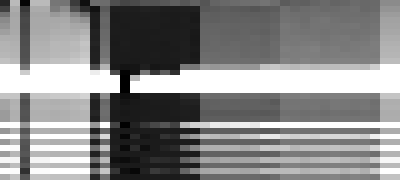

In [50]:
display(float_array_to_image((-np.log2(np.array(preds_after_fifty)+1e-30)).clip(0,30)/30))

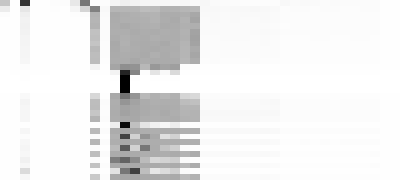

In [51]:
display(float_array_to_image(1 - np.array(preds_after_fifty) ** 0.5))